# Score compression of rescaled data (subsamples) with subsequent neural density estimation

In [47]:
!pip install -q git+https://github.com/justinalsing/pydelfi.git
 

importing packages (new pydelfi API)

In [0]:
import numpy as np
import sys
import pydelfi as delfi
import pydelfi.compression.score.score as score
import pydelfi.distributions.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [61]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [62]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [52]:
!ls

gdrive	sample_data


In [0]:
datapath='/content/gdrive/My Drive/LFIwithMnus/data/'

In [77]:
!ls /content/gdrive/My\ Drive/LFIwithMnus/data/

compressedSims.npy
covariance.npy
data_full_set_scaled.npy
data_scaled_means.npy
data_scaled.npy
MassiveNuS_params.txt
Om0.18159_As1.79315_mva0.02743_mvb0.02874_mvc0.05735_h0.70000_Ode0.81586_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy
Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy
Om0.20494_As2.63405_mva0.10004_mvb0.10040_mvc0.11200_h0.70000_Ode0.78815_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy
Om0.21184_As2.41979_mva0.09629_mvb0.09667_mvc0.10866_h0.70000_Ode0.78149_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy
Om0.21360_As1.76669_mva0.15048_mvb0.15072_mvc0.15868_h0.70000_Ode0.77624_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy
Om0.22372_As1.68717_mva0.05988_mvb0.06049_mvc0.07824_h0.70000_Ode0.77187_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy
Om0.22711_As2.71739_mva0.16652_mvb0.16674_mvc0.17397_h0.70000_Ode0.76170_Peaks_KN_s2.00_z1.00_ng40.00_b050.npy
Om0.22836_As1.86204_mva0.04545_mvb0.04625_mvc0.06784_h0.70000_Ode0.76808_Peaks_KN_s2.00_z1.00_ng40.00_b0

### load the data

In [0]:
# load data (note that order of params is not the same as data_sim)
data_scaled        = np.load(datapath+'data_full_set_scaled.npy')
data_scaled_full   = np.load(datapath+'data_scaled_means.npy')
data_scaled_cosmos = np.load(datapath+'params_conc.npy')
data_scaled_cosmos_full = np.load(datapath+'params_conc_means.npy')

covariance = np.load(datapath+'covariance.npy')

In [83]:
print(data_scaled.shape,data_scaled_cosmos_full.shape)

(101, 9999, 50) (101, 3)


In [84]:
# fiducial parameters (for compression)
index   = 51
index_0 = 53
theta_fiducial = data_scaled_cosmos_full[index]
print(theta_fiducial)


[0.1 0.3 2.1]


In [0]:
theta_cov = data_scaled_cosmos_full[index_0]

### Covariance Matrix

In [0]:
# compute covariance from covariance sims
Cov_Inv = np.linalg.inv(covariance)

### Gaussian process interpolation of (precompressed) data

In [0]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C


kernel = C(1.0, (1e-4, 1e4)) * RBF(1, (1e-4, 1e4))
#Instanciate a Gaussian Process model
gp     = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)


# fit on averages of full rescaled set
gp.fit(data_scaled_cosmos_full,data_scaled_full)

#use the GP prediction to build the model
def fitGP(theta):
    pred, stdev = gp.predict(np.array(theta).reshape(1,3),return_std=True)
    return pred.T

# compute derivative of mean at fiducial model with finite differencing

h      = 0.01

theta1 = np.asarray([theta_fiducial[0]*(1+h), theta_fiducial[1],theta_fiducial[2]])
theta1_= np.asarray([theta_fiducial[0]*(1-h), theta_fiducial[1],theta_fiducial[2]])

theta2 = np.asarray([theta_fiducial[0], theta_fiducial[1]*(1+h),theta_fiducial[2]])
theta2_= np.asarray([theta_fiducial[0], theta_fiducial[1]*(1-h),theta_fiducial[2]])

theta3 = np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1+h)])
theta3_= np.asarray([theta_fiducial[0], theta_fiducial[1],theta_fiducial[2]*(1-h)])

dmudt1 = (fitGP(theta1)-fitGP(theta1_))/(theta1-theta1_)[0]
dmudt2 = (fitGP(theta2)-fitGP(theta2_))/(theta2-theta2_)[1]
dmudt3 = (fitGP(theta3)-fitGP(theta3_))/(theta3-theta3_)[2]

# derivative
dmudt = np.hstack((dmudt1,dmudt2,dmudt3)).T

In [0]:
# set up scrore compression
mu             = fitGP(theta_fiducial)[:,0]
Cinv           = Cov_Inv


Compressor     = score.Gaussian(len(mu), theta_fiducial, mu = mu, Cinv = Cinv, dmudt = dmudt)
Compressor.compute_fisher()
Finv           = Compressor.Finv

def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

In [89]:
# compress all the (precompressed data) with compressor
compressed_train = np.zeros((data_scaled.shape[0],data_scaled.shape[1],3))
data_scaled_c    = np.zeros_like(compressed_train)
print(compressed_train.shape)
# compressed_train = np.reshape(compressed_train,newshape=(101,9999,3))
# data_scaled_c    = np.reshape(data_scaled_cosmos,newshape=(101,9999,3))
# data_scaled_= np.reshape(data_scaled,newshape=(101,9999,50))

# loop over cosmologies
for ii in range(compressed_train.shape[0]):
    for jj in range(compressed_train.shape[1]):
        compressed_train[ii][jj] = compressor(data_scaled[ii][jj],None)
        data_scaled_c[ii][jj] = data_scaled_cosmos_full[ii]
print(data_scaled_c.shape)

(101, 9999, 3)
(101, 9999, 3)


In [91]:
compressed_train1 = compressed_train[0:index,:,:]

compressed_train2 = compressed_train[index+1:,:,:]
print(compressed_train1.shape,compressed_train2.shape)
compressed_data   = compressed_train[index,:,:]
compressed_train_ = np.concatenate((compressed_train1,compressed_train2))
print(compressed_train_.shape, compressed_data.shape)

data_scaled_c1     = data_scaled_c[0:index,:,:]
data_scaled_c2     = data_scaled_c[index+1:,:,:]
data_scaled_c_data = data_scaled_c[index,:,:]
data_scaled_c_     = np.concatenate((data_scaled_c1,data_scaled_c2))
print(data_scaled_c_.shape, data_scaled_c_data.shape)

(51, 9999, 3) (49, 9999, 3)
(100, 9999, 3) (9999, 3)
(100, 9999, 3) (9999, 3)


In [92]:
compressed_train_ = np.reshape(compressed_train_,newshape=(-1,3))
data_scaled_c_    = np.reshape(data_scaled_c_,newshape=(-1,3))
print(data_scaled_c_.shape,compressed_train_.shape)

(999900, 3) (999900, 3)


### NDE estimation

In [93]:
# set up priors
lower = np.array([np.min(data_scaled_cosmos[:,0]),np.min(data_scaled_cosmos[:,1]),np.min(data_scaled_cosmos[:,2])])
upper = np.array([np.max(data_scaled_cosmos[:,0]),np.max(data_scaled_cosmos[:,1]),np.max(data_scaled_cosmos[:,2])])
print(upper, lower)
prior = priors.Uniform(lower, upper)

[0.62036 0.4159  2.9114 ] [0.     0.1841 1.2886]


In [0]:
import pydelfi.ndes.ndes as ndes

In [0]:
# NDEs you wanna train
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[50,50], n_mades=4, act_fun=tf.tanh, index=1),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[30,30], n_mades=5, act_fun=tf.tanh, index=2),
        ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=3, n_data=3, n_hiddens=[30,30], n_mades=6, act_fun=tf.tanh, index=3)]

In [0]:
DelfiEnsemble = delfi.Delfi(compressed_data[0], prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_fiducial, 
                            param_limits = [lower, upper],
                            param_names = ['M_\nu', '\Omega_m', 'A_s'], 
                            results_dir = "./",
                            input_normalization="fisher")

In [0]:
DelfiEnsemble.load_simulations(compressed_train_,data_scaled_c_)

In [102]:
DelfiEnsemble.fisher_pretraining()

Training:  17%|█▋        | 51/300 [02:37<11:35,  2.79s/it, train loss=3.66, val loss=3.68]

Training:   0%|          | 0/300 [00:00<?, ?it/s]

Training:   0%|          | 0/300 [00:00<?, ?it/s, train loss=0, val loss=0]

Training:   0%|          | 1/300 [00:03<19:51,  3.99s/it, train loss=0, val loss=0]

Training:   0%|          | 1/300 [00:03<19:51,  3.99s/it, train loss=13.7, val loss=13.5]

Training:   1%|          | 2/300 [00:07<19:44,  3.97s/it, train loss=13.7, val loss=13.5]

Training:   1%|          | 2/300 [00:07<19:44,  3.97s/it, train loss=8.76, val loss=8.68]

Training:   1%|          | 3/300 [00:11<19:07,  3.86s/it, train loss=8.76, val loss=8.68]

Training:   1%|          | 3/300 [00:11<19:07,  3.86s/it, train loss=6.94, val loss=6.92]

Training:   1%|▏         | 4/300 [00:15<18:34,  3.77s/it, train loss=6.94, val loss=6.92]

Training:   1%|▏         | 4/300 [00:15<18:34,  3.77s/it, train loss=6.17, val loss=6.16]

Training:   2%|▏         | 5/300 [00:18<18:08,  3.69s/it, 

In [103]:
DelfiEnsemble.train_ndes()





Training:   0%|          | 0/500 [00:00<?, ?it/s]



Training:   0%|          | 0/500 [00:00<?, ?it/s, train loss=0, val loss=0]



Training:   0%|          | 1/500 [00:24<3:21:21, 24.21s/it, train loss=0, val loss=0]



Training:   0%|          | 1/500 [00:24<3:21:21, 24.21s/it, train loss=3.56, val loss=3.56]



Training:   0%|          | 2/500 [00:47<3:19:16, 24.01s/it, train loss=3.56, val loss=3.56]



Training:   0%|          | 2/500 [00:47<3:19:16, 24.01s/it, train loss=3.59, val loss=3.59]



Training:   1%|          | 3/500 [01:10<3:15:12, 23.57s/it, train loss=3.59, val loss=3.59]



Training:   1%|          | 3/500 [01:10<3:15:12, 23.57s/it, train loss=3.51, val loss=3.51]



Training:   1%|          | 4/500 [01:33<3:13:30, 23.41s/it, train loss=3.51, val loss=3.51]



Training:   1%|          | 4/500 [01:33<3:13:30, 23.41s/it, train loss=3.5, val loss=3.5]  



Training:   1%|          | 5/500 [01:56<3:13:16, 23.43s/it, train loss=3.5, val loss=3.5]



Training:   1%|  

In [104]:
posterior_samples = DelfiEnsemble.emcee_sample()

/usr/local/lib/python3.6/dist-packages/pydelfi/delfi.py:184: RuntimeWarning: divide by zero encountered in log
  lnL = np.log(L)


Removed no burn in


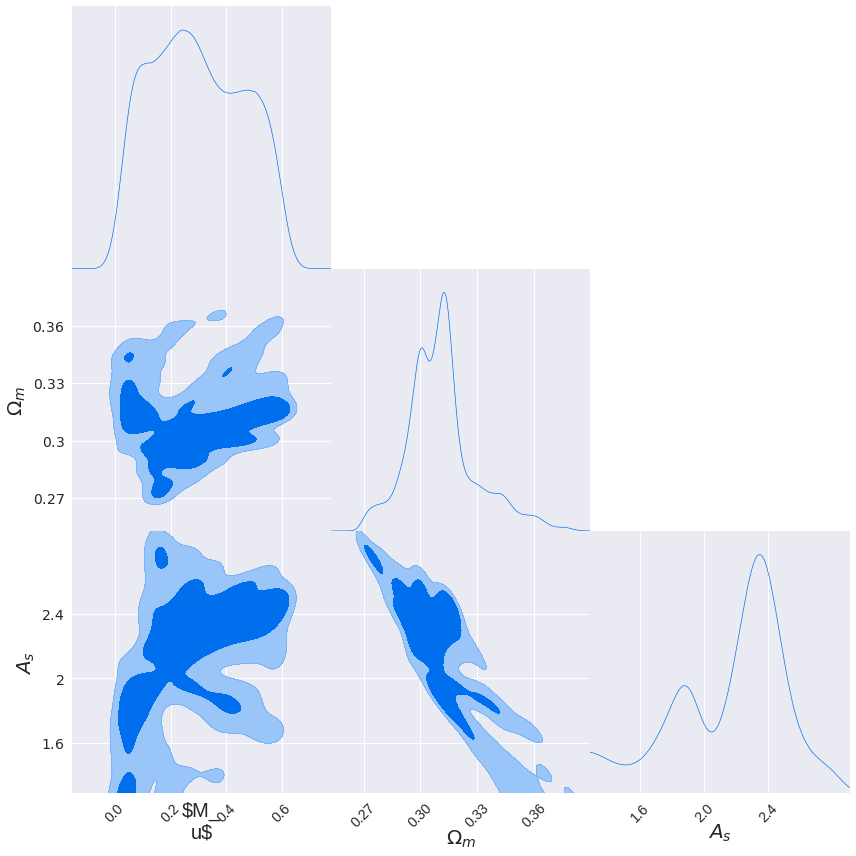

In [105]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])

In [0]:
samples = []
for i in range(4):
    samples.append(DelfiEnsemble.emcee_sample(log_likelihood=lambda x: DelfiEnsemble.log_posterior_individual(i, x)))

Removed no burn in


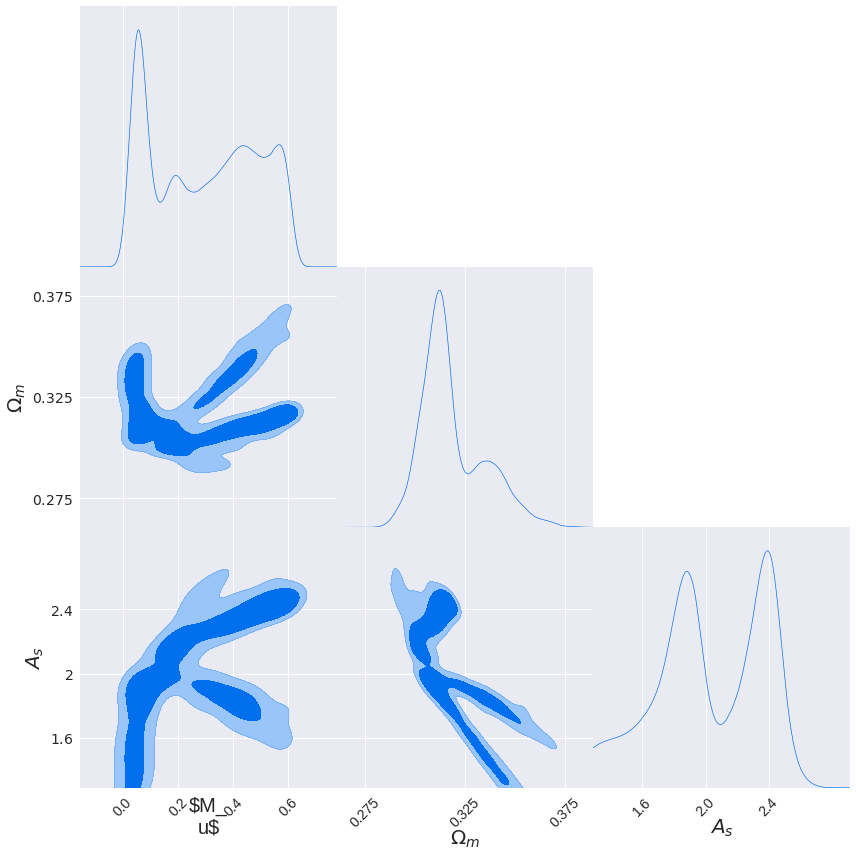

Removed no burn in


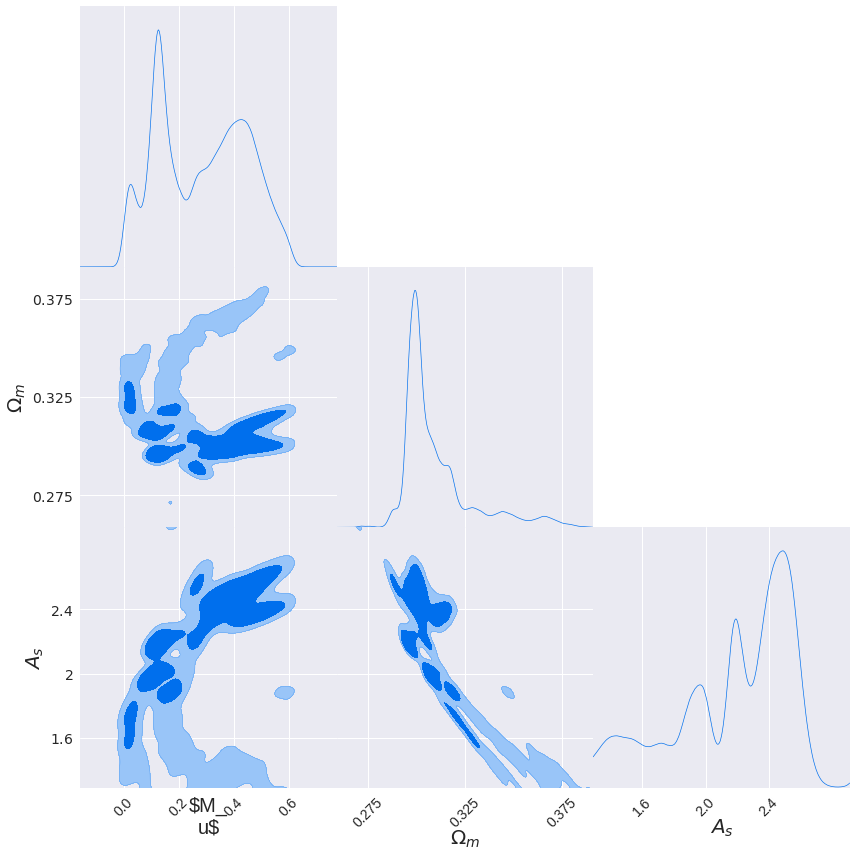

Removed no burn in


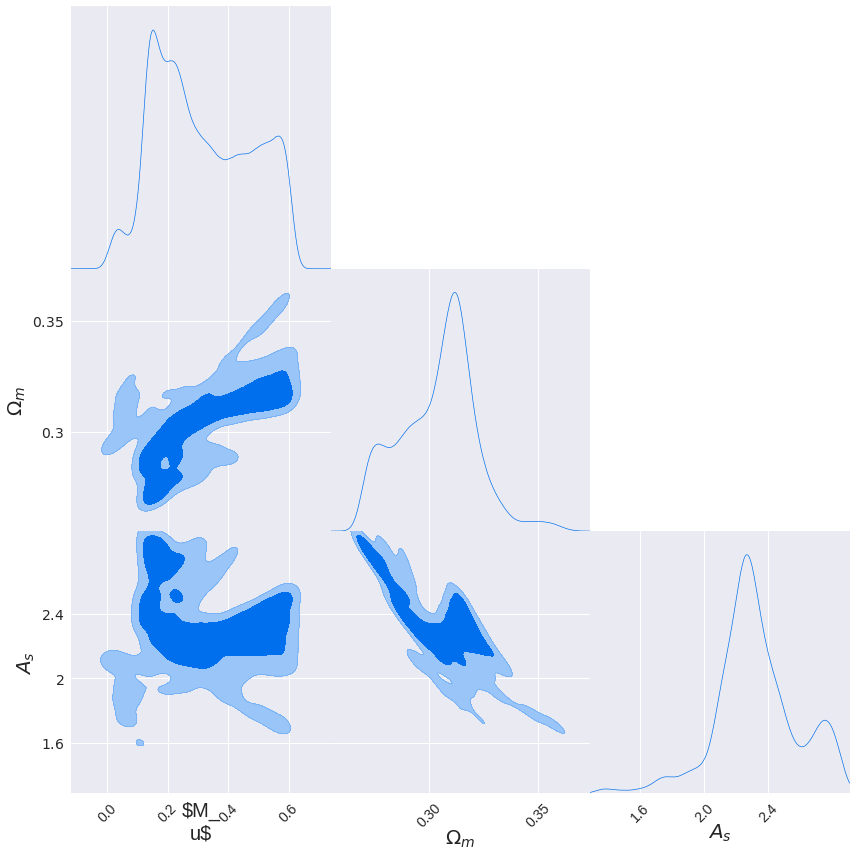

Removed no burn in


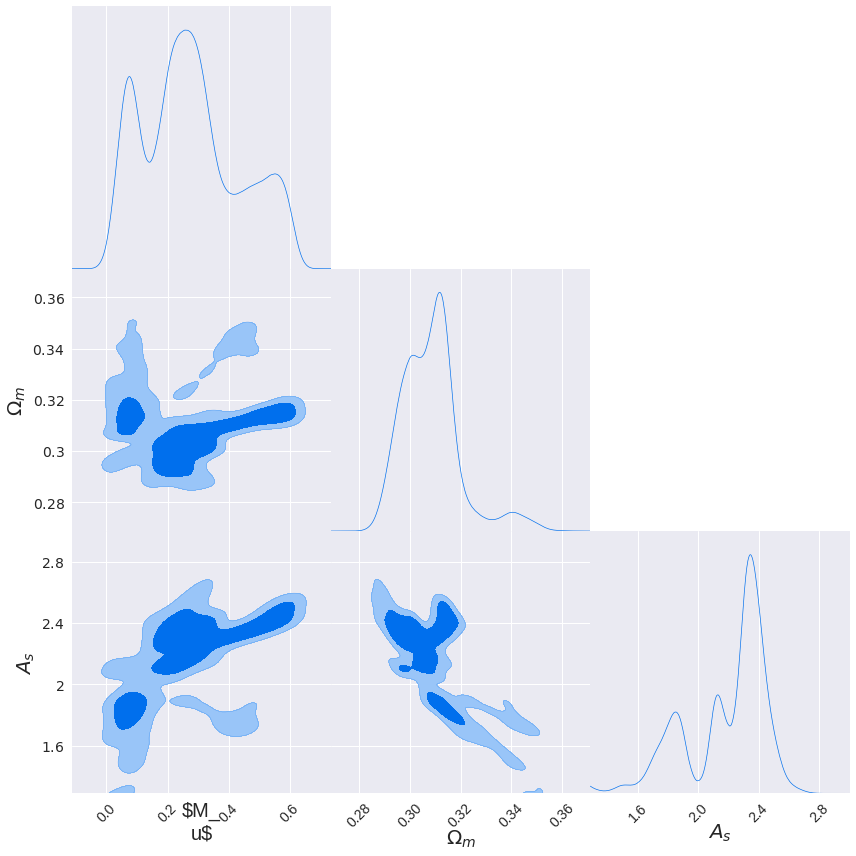

In [107]:
for i in range(4):
    DelfiEnsemble.triangle_plot(samples=samples[i:i+1])